<p><img style="padding: 0 15px; float: left;" src="Images/FTLogo300.jpg" alt="FT Crusader Logo" Width='140' Height= '250'/></p> 
<p> <h2> Interactive Crime Map Algorithm Workbook; 05/06/19</h2> <a name="tc"></a>
<p> <h3> By Frogtown Crusader (Abu Nayeem)</h3>

### Table of Contents

* [Intro](#intro)
* [General Data Setup](#setup)
* Decoding Intersection 
    * [Hardcode Intersection Key Steps](#hard)
    * [Intersection Key Setup](#setup_inter)
    * [Intersection Table Setup](#setup_table)
    * [Merging Intersection Table](#merge_inter)
* Decoding Address
    * [Intro/setup](#setup_add)
    * [Google Geocoder In-depth explanation](#geo_explain)
    * [Annotated Geocoder Example](#ann_workbook)
    * [Bare Geocoder Workbook](#workbook)
    * [Geocoder Aggregation](#agg)
    * [Address Key Preparation](#address_key)
    * [Algorithm Maintenance](#maintenance)
* Alternative Algorithm: Absolute Decoder
    * [Decoder Steps](#abs_decode)
    * [Visualizing Outliers](#out)
    * [Decoder Cleanup](#decode_clean)



### Intro   <a name="Intro"></a>

The goal of this notebook is to illustrate the notes and steps needed to prepare interactive crime data for Saint Paul and the steps needed to create a proxy algorithm for geo-coordinates. This workbook is focused in tuning the proxy algorithm. 

The [Crime Incident Report - Dataset](https://information.stpaul.gov/Public-Safety/Crime-Incident-Report-Dataset/gppb-g9cg) was obtained from the Saint Paul Website. It is publicly available. The report contains incidents from Aug 14 2014 through the most recent date, as released by the Saint Paul Police Department.

### Proxy Algorithm

**Challenge:**
* How can we find the geo-coordinates of a masked column?

**Values of Column:**
* '45X University Ave' i.e Masked Address
* 'Victoria Street and Avon Avenue' i.e. Intersection

**Strategy:** The algorithm will treat both steps separately; where I split the data between Intersection and Mashed Address and combined them back. (More details as we code!)
* PreCoding: For __Intersection Key__, we will find the geocoordinates of all potential intersections of interest and save it as Key Table



#### Data Setup <a name="setup"></a>

I will be using the Socrata API to download data. There are some advantages and disadvantages. For advantage, I don't have to store data directly. The disadvantage is that the API is clunky and the column order and datatypes changes!

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly
from pygeocoder import Geocoder #GeoCoding Algorithm
import folium
from IPython.display import HTML
from IPython.display import display
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sodapy import Socrata

In [2]:
pf = pd.DataFrame.from_records(results)
pf.shape
#Grid_Index= [66,67, 68, 86, 87,88,89, 90, 91, 92,106,107,108,109,110]
cols= ['Block','CallDispCode','CallDisposition','Case','Code', 'Count','Date','Grid','Incident','IncType','Neighborhood','NNum','Time']
pf.columns= cols
pf = pf.astype({"Case": int, "Code": int, "Grid":float, "NNum":int,"Count":int})
pf=pf.query("Grid in (66,67, 68, 86, 87,88,89, 90, 91, 92,106,107,108,109,110)")
pf.shape


['Armatage', 'Lind - Bohanon', 'McKinley', 'Harrison', 'Hawthorne',
       'Como', 'Folwell', 'Howe', 'Willard - Hay', 'North Loop',
       'Linden Hills', 'Northeast Park', 'Elliot Park', 'Standish',
       'Near - North', 'East Harriet', 'Powderhorn Park', 'Audubon Park',
       'Longfellow', 'Lowry Hill East', 'Marshall Terrace', 'Jordan',
       'Keewaydin', 'Beltrami', 'Northrop', 'Field', 'Hale', 'Logan Park',
       'Sheridan', 'St. Anthony West', 'St. Anthony East', 'Tangletown',
       nan, 'Minnehaha', 'Fulton', 'Morris Park', 'Wenonah', 'Kenny',
       'Windom', 'Hiawatha', 'Seward', 'Loring Park', 'Windom Park',
       'East Phillips', 'King Field', 'East Isles', 'West Maka Ska',
       'Central', 'Diamond Lake', 'Lowry Hill',
       'Nicollet Island - East Bank', 'Victory', 'Lyndale', 'Holland',
       'East Bde Maka Ska', 'Marcy Holmes', 'Bottineau', 'Bryant',
       'South Uptown', 'Midtown Phillips', 'Bancroft', 'Whittier',
       'Prospect Park - East River Road', 'Ventura Village',
       'Downtown West', 'Page', 'Phillips West', 'Webber - Camden',
       'Corcoran', 'Waite Park', 'Lynnhurst', 'Columbia Park', 'Cooper',
       'Cedar Riverside', 'Cedar - Isles - Dean',
       'University of Minnesota', 'Cleveland', 'Ericsson',
       'Downtown East', 'Bryn - Mawr', "Steven's Square - Loring Heights",
       'Kenwood', 'Shingle Creek', 'Regina', 'Mid - City Industrial',
       'Sumner - Glenwood', 'Camden Industrial']

NameError: name 'results' is not defined

In [35]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly
from pygeocoder import Geocoder #GeoCoding Algorithm
import folium
from IPython.display import HTML
from IPython.display import display
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sodapy import Socrata

#New Upload Method Get Information from Socrata API
client = Socrata("information.stpaul.gov", None)

#Easier to bulk upload
results = client.get("gppb-g9cg", limit=1000000)
df = pd.DataFrame.from_records(results)
# Find Max Date Value
results = client.get("gppb-g9cg", limit=1)
r_max = pd.DataFrame.from_records(results)


#NOT USED SPECIFIC ENTRY
# Upload data based on grid; I couldnt figure out Socrata API
#results = client.get("gppb-g9cg", limit=5000, grid=(66))
#r66 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(67))
#r67 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(68))
#r68 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(86))
#r86 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(87))
#r87 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(88))
#r88 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(89))
#r89 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(90))
#r90 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(91))
#r91 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(92))
#r92 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(106))
#r106 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(107))
#r107 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(108))
#r108 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(109))
#r109 = pd.DataFrame.from_records(results)
#results = client.get("gppb-g9cg", limit=5000, grid=(110))
#r110 = pd.DataFrame.from_records(results)
#Combine all the datatables                     
#df= pd.concat([r66,r67,r68,r86,r87,r88,r89,r90,r91,r92,r106,r107,r108,r109,r110],ignore_index=True)

#rename columns [Note the order of Columns have changed]
cols= ['Block','CallDispCode','CallDisposition','Case','Code', 'Count','Date','Grid','Incident','IncType','Neighborhood','NNum','Time']
df.columns= cols
df = df.astype({"Case": int, "Code": int, "Grid":float, "NNum":int,"Count":int})
#select respective Grids of interest
df=df.query("Grid in (66,67, 68, 86, 87,88,89, 90, 91, 92,106,107,108,109,110)")


# Old Method
#df_crime = pd.read_csv('Datasets/Crime_Incident_Report_-_Dataset.csv')
#cols= ['Case','Date','Time','Code','IncType','Incident','Grid','NNum','Neighborhood','Block','CallDispCode','CallDisposition', 'Count']
#df.columns= cols
#print(df_crime.head())

print(df.shape)
print(df.dtypes)



(26802, 13)
Block               object
CallDispCode        object
CallDisposition     object
Case                 int32
Code                 int32
Count                int32
Date                object
Grid               float64
Incident            object
IncType             object
Neighborhood        object
NNum                 int32
Time                object
dtype: object


### Create New Variables 

In [36]:
#Add Time Variables
df= df[df.Case != 18254093] #messed up time variable

#Convert Date to Datetime!
from datetime import datetime

df['DateTime']= pd.to_datetime(df['Date']) # Create new column called DateTime
df['Year']= df['DateTime'].dt.year #create year column
df['DayofWeek']=df['DateTime'].dt.dayofweek #create day of the week column where default 0=Monday
df['Weekend'] = df['DayofWeek'].apply(lambda x: 1 if (x>4)  else 0) #Create a weekend category
df['Month'] = df['DateTime'].dt.month # Create Month Category
df['Day'] = df['DateTime'].dt.day #Create Day of the Current month
df['DayYear'] = df['DateTime'].dt.dayofyear  #Create Day of the year (0-365)

#Find max-day:
r_max['DateTime']= pd.to_datetime(r_max['date'])
r_max['DayYear'] = r_max['DateTime'].dt.dayofyear  #Create Day of the year (0-365)
df['Day_Max'] = r_max.iloc[0,-1] #selects uptodate day; NOTE: the data is sorted chronologically

#Hour Data
df['TimeHour']= pd.to_datetime(df['Time'])
df['Hour'] = df['TimeHour'].dt.hour.astype(int) #Create Hour Colum
df['LateNight'] = df['Hour'].apply(lambda x: 1 if (x>21 or x<5)  else 0) #Latenight designation from 10Pm to 6PM

#Creating the intersection Column. Note: the Block column has the address information
df.Block = df.Block.astype(str) #first change the type to string
df['Block']= df['Block'].str.lower() #lowercase string to create uniformity

#While scanning the data I noticed that all intersections had "&" 
df['Intersection'] = df['Block'].apply(lambda x: 1 if '&' in x else 0) #intersection

df.head(5)

,Block,CallDispCode,CallDisposition,Case,Code,Count,Date,Grid,Incident,IncType,...,DayofWeek,Weekend,Month,Day,DayYear,Day_Max,TimeHour,Hour,LateNight,Intersection
0,127x seminary av,A,Advised,18032373,9954,1,2018-02-14T00:00:00.000,66.0,Proactive Police Visit,Proactive Police Visit,...,2,0,2,14,45,121,2019-05-11 21:43:46,21,0,0
1,117x piercebutler rd,A,Advised,17275739,9954,1,2017-11-28T00:00:00.000,66.0,Proactive Police Visit,Proactive Police Visit,...,1,0,11,28,332,121,2019-05-11 20:50:00,20,0,0
2,121x piercebutler rd,RR,Report Written,17274739,535,1,2017-11-27T00:00:00.000,66.0,Burglary,"Burglary, Forced Entry, Day, Commercial",...,0,0,11,27,331,121,2019-05-11 13:30:00,13,0,0
3,127x hewitt av,A,Advised,17182301,9954,1,2017-08-04T00:00:00.000,66.0,Proactive Police Visit,Proactive Police Visit,...,4,0,8,4,216,121,2019-05-11 20:24:51,20,0,0
4,127x hewitt av,A,Advised,17156986,9954,1,2017-07-07T00:00:00.000,66.0,Proactive Police Visit,Proactive Police Visit,...,4,0,7,7,188,121,2019-05-11 23:58:06,23,1,0


### Hardcoding Intersection Key <a name="hard"></a>

0) Create a DataSheet (i.e Excel or GoogleSheet [preferred]) 
    * Setup four columns IntersectionID (used as index), IntersectionName1; IntersectionName2; and clumped geocoordinates 
    * A grid column  is not included because that data can be messy and it's not clear what grid a boundary intersection will be located
    * Do not worry about undercase and uppercase
    * The actual location data is not consistent in the order it names an intersection; so I have created a post-code so you don't need to enter data a second time
    * Avoid double-count when entering the data! Don't worry we will perform some debugging and error checks
    
1) List all possible intersections of interest. Use the [police grid boundaries](https://information.stpaul.gov/Public-Safety/Saint-Paul-Police-Grid-Shapefile/ykwt-ie3e) when selecting intersections of Interest.
    * To address the boundary problem I've included the neighboring police grids of Frogtown to assure all relevant points are being mapped. However, the boundary problem does exist at the outer boundaries.

2) Strategy for Setup: Often urban areas are organized in a grid; so intersections can follow a pattern where two avenues have almost the same intersection pairs. You can copy and paste some of the columns, etc. See picture below
    * Make sure you set the naming of the intersections in the way you actually scroll down on a map to enter data. (Saves a lot of time in data entry)
    * Go to Google Maps on a web browser and point to an intersection until you some geocoordinates come up and then click on the geocoordinates hyperlink; From that window, you copy and paste the geocoordinates. You could manual enter the values separately, but it will make the process much tedious. The post code can handle it much readily

3) Since the intersection key is a static document, I recommend exporting it as csv and loading it to your machine

### Setup Intersection Key <a name="setup_inter"></a>

In this step, I'll be loading the Intersection Key File and prep it up for joining the primary dataset. The primary key is the name of the intersection; the format I decided to go with is 'name1_name2'. However, 'name2_name1' is also valid and should have same coordinates. The final dataframe has an indexkey to connect to join with the primary output key. 

**Note:** I discovered the bugs of the code during the data exploration phase.

In [402]:
#Setting up the Coordinate Key

#Prep from appropiate key (note this process can be done in excel as well)
df_key= pd.read_csv('Datasets/Frog_key - Sheet1.csv')

#convert to lowercase
df_key['Intersection1']= df_key['Intersection1'].str.lower()
df_key['Intersection2']= df_key['Intersection2'].str.lower()
#remove empty space; found out when debugging!
df_key['Intersection1']= df_key['Intersection1'].str.replace(' ', '', regex=True)
df_key['Intersection2']= df_key['Intersection2'].str.replace(' ', '', regex=True)

df_key.head(2)


,IntersectionID,Intersection1,Intersection2,Coordinates
0,1,lexington,front,"44.970295, -93.146572"
1,2,lexington,stinson,"44.969316, -93.146529"


In [403]:
#Create a dataframe and new columns on potential mapping
A=df_key[['Intersection1','Intersection2', 'Coordinates']]
A['Int1_2']= A['Intersection1']+ '_' + A['Intersection2'] #int1_int2
A['Int2_1']= A['Intersection2']+ '_' + A['Intersection1'] #int2_int1
A['OutputKey']= A['Int1_2'] #create an output key based on oneinstersection pair
A.head(2)

#A.query('Int=="marshall_victoria"')
#A.query('Intersection1=="marshall"')
#Intersection_key.query('IndexKey=="marshall_victoria"')


,Intersection1,Intersection2,Coordinates,Int1_2,Int2_1,OutputKey
0,lexington,front,"44.970295, -93.146572",lexington_front,front_lexington,lexington_front
1,lexington,stinson,"44.969316, -93.146529",lexington_stinson,stinson_lexington,lexington_stinson


In [404]:
# Take a subset of data and rename the Int columns to IndexKey
H1=A[['Int1_2','Coordinates','OutputKey']]
H1.columns= ['IndexKey','Coordinates','OutputKey']
H2=A[['Int2_1','Coordinates','OutputKey']]
H2.columns= ['IndexKey','Coordinates','OutputKey']

#We finally merge the two columns
Intersection_key=H1.append(H2, ignore_index=True)
Intersection_key.tail(2)
Intersection_key.to_csv('Intersection_key_clean.csv', encoding='utf-8', index=False)


### Setup Intersection DataTable <a name="setup_table"></a>

We have prepared the key, but we need to prepare datatable to match with the IndexKey. This will require several string splittings.

In [6]:
# Create a new dateframe specifying only intersections
dfI=df.query('Intersection ==1')
print('The intersection table dimension are ' + str(dfI.shape))
print(dfI.Block.head(10))

The intersection table dimension are (4948, 25)
182              dale st n & edmund
257            milton st n & thomas
258           thomas av  & stalbans
266             energy la  & norris
315        arundel st  & university
368         hubbard av  & syndicate
416             thomas av  & milton
467             thomas av  & milton
539    chatsworth st n & university
601            dale st n & marshall
Name: Block, dtype: object


**Strategy:** Do you see a pattern?

1) Split the string to two sections on the ' ', the first section has an intersection variable

2) Split the string to two sections on the '& ', the second section has an intersection variable

3) Note: The avenue and direction does not matter for our purposes and probability that there is same named street and avenue having the same paired intersection is unlikely

In [7]:
#Split the strings
new=dfI['Block'].str.split("& ", n = 1, expand = True) 
dfI['Inter2']= new[1]
new=dfI['Block'].str.split(" ", n = 1, expand = True) #Note the code specifies the first time a space occured
dfI['Inter1']=new[0]

#Create the IndexKey; recall we prepared the IntersectionKey where we consider any order
dfI['IndexKey']= dfI['Inter1']+ '_' + dfI['Inter2']
dfI.reset_index()
dfI=pd.merge(dfI, Intersection_key, on='IndexKey', how='left')
dfI.head(3)



,Case,Date,Time,Code,IncType,Incident,Grid,NNum,Neighborhood,Block,...,Day_Max,TimeHour,Hour,LateNight,Intersection,Inter2,Inter1,IndexKey,Coordinates,OutputKey
0,19088395,04/30/2019,2019-04-30T08:00:00.000,861,"Assault, Domestic, Opposite Sex",Simple Asasult Dom.,89.0,7,7 - Thomas/Dale(Frogtown),dale st n & edmund,...,120,2019-04-30 08:00:00,8,0,1,edmund,dale,dale_edmund,"44.958439, -93.126376",dale_edmund
1,19088075,04/29/2019,2019-04-29T21:40:24.000,9954,Proactive Police Visit,Proactive Police Visit,87.0,7,7 - Thomas/Dale(Frogtown),milton st n & thomas,...,120,2019-04-29 21:40:24,21,0,1,thomas,milton,milton_thomas,"44.959361, -93.139031",milton_thomas
2,19088071,04/29/2019,2019-04-29T21:39:13.000,9954,Proactive Police Visit,Proactive Police Visit,88.0,7,7 - Thomas/Dale(Frogtown),thomas av & stalbans,...,120,2019-04-29 21:39:13,21,0,1,stalbans,thomas,thomas_stalbans,"44.959350, -93.128908",stalbans_thomas


### Merging Intersection Data <a name="merge_inter"></a>

Check which intersections have not matched and the respective count

In [8]:
#Check if any missing values

#find null subset
B= dfI[dfI['Coordinates'].isnull()]
C=B[['Neighborhood','IndexKey']]
#C=C.query('Neighborhood != "7 - Thomas/Dale(Frogtown)"')
#C.groupby(['Neighborhood','IndexKey']).sum()
#C.IndexKey.value_counts()

In [9]:
#Drop rows with missing coordinates
dfI=dfI[dfI['Coordinates'].notnull()]

# Separate Latitude and Longitude 
new=dfI['Coordinates'].str.split(",", n = 1, expand = True) 
# making seperate first name column from new data frame 
dfI['Latitude']= pd.to_numeric(new[0]) #pd.to_numeric convert it to float
dfI['Longitude']= pd.to_numeric(new[1])


Index(['Case', 'Date', 'Time', 'Code', 'IncType', 'Incident', 'Grid', 'NNum',
       'Neighborhood', 'Block', 'CallDispCode', 'CallDisposition', 'Count',
       'DateTime', 'Year', 'DayofWeek', 'Weekend', 'Month', 'Day', 'DayYear',
       'Day_Max', 'TimeHour', 'Hour', 'LateNight', 'Intersection', 'Inter2',
       'Inter1', 'IndexKey', 'Coordinates', 'OutputKey', 'Latitude',
       'Longitude'],
      dtype='object')

In [158]:
#Final Load
dfI['Block']=dfI['OutputKey'] #for practical purposes it makes sense
Drop_col=['Inter2','Inter1', 'IndexKey', 'Coordinates', 'OutputKey']
dfI_Final=dfI.drop(Drop_col, axis=1,)
dfI_Final.head(5)

,Case,Date,Time,Code,IncType,Incident,Grid,NNum,Neighborhood,Block,...,Month,Day,DayYear,Day_Max,TimeHour,Hour,LateNight,Intersection,Latitude,Longitude
0,19078070,04/17/2019,15:05,9954,Proactive Police Visit,Proactive Police Visit,109.0,8,8 - Summit/University,arundel_central,...,4,17,107,107,2019-04-30 15:05:00,15,0,1,44.953081,-93.118654
1,19078068,04/17/2019,15:03,9954,Proactive Police Visit,Proactive Police Visit,110.0,8,8 - Summit/University,farrington_fuller,...,4,17,107,107,2019-04-30 15:03:00,15,0,1,44.953989,-93.113264
2,19078110,04/17/2019,16:08,9954,Proactive Police Visit,Proactive Police Visit,89.0,7,7 - Thomas/Dale(Frogtown),mackubin_university,...,4,17,107,107,2019-04-30 16:08:00,16,0,1,44.955842,-93.121236
3,19078182,04/17/2019,17:22,9954,Proactive Police Visit,Proactive Police Visit,87.0,7,7 - Thomas/Dale(Frogtown),lexington_university,...,4,17,107,107,2019-04-30 17:22:00,17,0,1,44.955826,-93.146539
4,19078441,04/17/2019,23:48,9954,Proactive Police Visit,Proactive Police Visit,87.0,7,7 - Thomas/Dale(Frogtown),milton_thomas,...,4,17,107,107,2019-04-30 23:48:00,23,1,1,44.959361,-93.139031


## Figuring out the Address Key <a name="setup_add"></a>

So how do we get geocoordinates from masked address?

The intended strategy was to fill in the missing values with numericals and have a geo-coder application convert it to coordinates. First, I tried the 'Nominator' that is an built-in Geocoder function. It failed quite horribly even for actual addresses. On the other hand, Google's API is very good at approximating address including those that don't necessarily exist. It was not entirely perfect, but had success rate of around 96%. The drawback of the Google API is that it is not fully automated or at least I am not aware how to do it

Note: If I truly desired to go overkill, I could create a centroid boundary where the address can be located based on the geo-coordinates on the intersections previously mapped out. If out of boundary, then incorrectly matched

#### Basic Setup

I will be applying a geocoder function on an entire column. It took some tinkering to setup the Google API into a function where the API specified is default. I borrowed the code from somewhere, but I have broken down the output below and explain how to get raw data and get other information.

Let's find the output of getting the address of a single location: '90 Grotto Street, St. Paul, MN, 55103'

In [58]:
#First component URL
geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address=490 Grotto Street, St. Paul, MN, 55103"
# Second Compoent URL (add API)
geocode_url = geocode_url + "FILLME"
#Ping Result
output = requests.get(geocode_url)
# Results will be in JSON format - convert to dict using requests functionality
output = output.json()

output

{'results': [{'address_components': [{'long_name': '490',
     'short_name': '490',
     'types': ['street_number']},
    {'long_name': 'Grotto Street North',
     'short_name': 'Grotto St N',
     'types': ['route']},
    {'long_name': 'West Frogtown',
     'short_name': 'West Frogtown',
     'types': ['neighborhood', 'political']},
    {'long_name': 'Saint Paul',
     'short_name': 'St Paul',
     'types': ['locality', 'political']},
    {'long_name': 'Ramsey County',
     'short_name': 'Ramsey County',
     'types': ['administrative_area_level_2', 'political']},
    {'long_name': 'Minnesota',
     'short_name': 'MN',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'United States',
     'short_name': 'US',
     'types': ['country', 'political']},
    {'long_name': '55104', 'short_name': '55104', 'types': ['postal_code']}],
   'formatted_address': '490 Grotto St N, St Paul, MN 55104, USA',
   'geometry': {'location': {'lat': 44.9560645, 'lng': -93.131192

This is a messy JSON file but its organized by dictionaries and lists. Most of the information is in first column. It is then followed by a dictionary, whom have possibly nested dictionaries and lists.

### Explaining geo-coder/json file <a name="geo_explain"></a>

I will briefly explain what is a json file and how we use python to get information below. First, a json file is website information data; similar to that of html. The geo-coder is essentially getting information as if I entered geo-coordinates using the google map application. I annotate the structure of the JSON file below.  

**Note**: 

1) The results have a hidden list category '[0]'; the address selected only pinged one listing; IF there was two listing, we would need to specify the second list. Even if one entry is displayed, we still need to specify the first list item.  

2) The entry index for the address_column varies which crashes the code if selecting from normal progression; instead the final index, [-1] is selected to receive the zip code entry; Note: I found this out from debugging 
    * I was still getting the incorrect index, so I created a conditional argument to find the correct index

In [ ]:
#dictionary
    #LIST HIDDEN layer, because one value came up; if two entries come up
    {'results':
    #dictionary
    {
        'address_components': 
        #list
        [
            #dictionary
            { 
            'long_name': '490',
            'short_name': '490',
            'types': ['street_number']
            }, #end list entry 1
    {'long_name': 'Grotto Street North',
    'short_name': 'Grotto St N',
    'types': ['route']},
  {'long_name': 'West Frogtown',
   'short_name': 'West Frogtown',
   'types': ['neighborhood', 'political']},
  {'long_name': 'Saint Paul',
   'short_name': 'St Paul',
   'types': ['locality', 'political']},
  {'long_name': 'Ramsey County',
   'short_name': 'Ramsey County',
   'types': ['administrative_area_level_2', 'political']},
  {'long_name': 'Minnesota',
   'short_name': 'MN',
   'types': ['administrative_area_level_1', 'political']},
  {'long_name': 'United States',
   'short_name': 'US',
   'types': ['country', 'political']},
  {'long_name': '55104', 'short_name': '55104', 'types': ['postal_code']}
        ]  #endlist,
 
 'formatted_address': '490 Grotto St N, St Paul, MN 55104, USA',
 
 'geometry': 
    #dictionary
    {'location':
         #dictionary
         {'lat': 44.9560645, 'lng': -93.1311927},
              'location_type': 'RANGE_INTERPOLATED',
              'viewport': {'northeast': {'lat': 44.95741348029149,'lng': -93.12984371970849},
                           'southwest': {'lat': 44.95471551970849, 'lng': -93.13254168029151}
                          }
             },
 'place_id': 'Eic0OTAgR3JvdHRvIFN0IE4sIFN0IFBhdWwsIE1OIDU1MTA0LCBVU0EiGxIZChQKEgnBnPtqgir2hxGHkz1OfBptEhDqAw',
 'types': ['street_address']
# second macro dictionary entry
 'status': 'OK'}
}

Notice that there are many nested dictionaries and lists in the data; 
* To select on list value we point to the list index, []
* To select on dictionary value, .get(dictionary_key)

In [110]:
#Get Latitude
print('The latitude is ' + str(output.get('results')[0].get('geometry').get('location').get('lat')))
#Get ZipCode
print('The zip is ' + str(output.get('results')[0].get('address_components')[-1].get('long_name'))) #selected seventh entry in address components


The latitude is 44.9560645
The zip is 55104


In [3]:
import geocoder 
import requests
#geocoder.google("1022 edmund avenue west, St. Paul, MN, 55104", key=API_KEY)

def get_google_results(address, api_key='FillMe', return_full_response=False):
    """
    Get geocode results from Google Maps Geocoding API.
    
    Note, that in the case of multiple google geocode reuslts, this function returns details of the FIRST result.
    
    @param address: String address as accurate as possible. For Example "18 Grafton Street, Dublin, Ireland"
    @param api_key: String API key if present from google. 
                    If supplied, requests will use your allowance from the Google API. If not, you
                    will be limited to the free usage of 2500 requests per day.
    @param return_full_response: Boolean to indicate if you'd like to return the full response from google. This
                    is useful if you'd like additional location details for storage or parsing later.
    """
    # Set up your Geocoding url
    geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address={}".format(address)
    if api_key is not None:
        geocode_url = geocode_url + "&key={}".format(api_key)
        
    # Ping google for the reuslts:
    results = requests.get(geocode_url)
    # Results will be in JSON format - convert to dict using requests functionality
    results = results.json()
#    results =results['formatted_address']
    
    # if there's no results or an error, return empty results.
    zip_index=0
    if len(results['results']) == 0:
        output = {
            "formatted_address" : None,
            "latitude": None,
            "longitude": None
            ,"zip": None
            
        }
    else:    
        answer = results['results'][0]
        for x,j in enumerate(answer.get('address_components')):
            if j.get('types')[0]=='postal_code':
                zip_index=x
            else:
                pass
        output = {
            "formatted_address" : answer.get('formatted_address'),
            "latitude": answer.get('geometry').get('location').get('lat'),
            "longitude": answer.get('geometry').get('location').get('lng')
            ,"zip": answer.get('address_components')[zip_index].get('long_name')
        }
        
    # Append some other details:    
    output['input_string'] = address
    # how many number of results displayed
    output['number_of_results'] = len(results['results'])
    #was it succesfully executed
    output['status'] = results.get('status')
    if return_full_response is True:
        output['response'] = results
    
    return output

get_google_results('500 Grotto St N, Saint Paul, MN, 55104')

### Geocoder Algorithm Annotated Steps <a name="ann_workbook"></a>

The limitation of the Google API is that there is a time-out when doing many entries (100 is too much), so I would have to do batches of 50 in plugging in the algorithm. The Google API spits out an address associated with the provided geo-coordinates, which can be used to determine if it is a good match.

The correct zip code is very important for the algorithm to run more accurately.


In [48]:
dfW=df.query('Intersection==0')
dfW=dfW.query('Grid in [86.0]') #Perform algorithm separately for each grid

#I tried different specifications to improve accuracy; In retrospect, I should of given the xx value a different value just for graphical purposes
dfW['Block1']= dfW.Block.str.replace('xx','05')
dfW['Block1']= dfW.Block1.str.replace('x ','0 ') #notice the space

#special Case!
dfW['Block1']= dfW.Block1.str.replace('ravou0','ravoux')

# Set it up for Address format; get a general idea on the zipcode of the dataset
dfW['Address']= dfW['Block1'] + ', Saint Paul, MN, 55104'

# Create a datatable showing original, transformed, and full address
A=dfW[['Grid','Block','Block1','Address']].sort_values('Address')
#Note: the groupby gets unique addresses
A=A.groupby(['Grid','Address','Block']).count()
A=A.reset_index()
A.shape


(222, 4)

Based on the above dimensions, we create 50 entry bins 

In [49]:
#Creating 50 bins
B=A.loc[0:50,:]
C=A.loc[51:100,:]
D=A.loc[101:150,:]
E=A.loc[151:200,:]
F=A.loc[201:,]
#G=A.loc[251:,]

When running the algorithm, wait until one section finishes and then run the next one. We are savings the results of the output in a new column called "Coordinates". 

We create a function that runs the algorithm and display the results. We are looking for results that don't match. You should right down the indexes on a piece of paper. Notice the column, Fail, which indicates the entry did not fit zip code parameters; this parameter will also indicate; if this raw entry has been misplaced. 

In [4]:

def run_geo_algorithm(data,zipcode):
    data['Coordinates']= data['Address'].apply(get_google_results)
    data['For_Address'] = data['Coordinates'].apply(lambda x: x['formatted_address'])
    data['Latitude'] = data['Coordinates'].apply(lambda x: x['latitude']) 
    data['Longitude'] = data['Coordinates'].apply(lambda x: x['longitude']) 
    data['Zip'] = data['Coordinates'].apply(lambda x: x['zip']) 
    data['Results'] = data['Coordinates'].apply(lambda x: x['number_of_results']) 
    data['Fail'] = data['Coordinates'].apply(lambda x: x['zip'] in zipcode) 
    return data[['For_Address', 'Block','Zip','Results','Fail']]



In [55]:
#run it for each letter
run_geo_algorithm(F,['55104'])    

,For_Address,Block,Zip,Results,Fail
201,"474 Lexington Pkwy N, St Paul, MN 55104, USA",59x lexington pa n,55104,1,True
202,"590 N Syndicate St, St Paul, MN 55104, USA",59x syndicate st n,55104,1,True
203,"600 N Dunlap St, St Paul, MN 55104, USA",60x dunlap st n,55104,1,True
204,"600 N Griggs St, St Paul, MN 55104, USA",60x griggs st n,55104,2,True
205,"600 Hamline Ave N, St Paul, MN 55104, USA",60x hamline av n,55104,1,True
206,"474 Lexington Pkwy N, St Paul, MN 55104, USA",60x lexington pa n,55104,1,True
207,"610 N Dunlap St, St Paul, MN 55104, USA",61x dunlap st n,55104,1,True
208,"610 N Griggs St, St Paul, MN 55104, USA",61x griggs st n,55104,1,True
209,"610 Lexington Pkwy N, St Paul, MN 55104, USA",61x lexington pa n,55104,1,True
210,"620 Lexington Pkwy N, St Paul, MN 55104, USA",62x lexington pa n,55104,1,True


We then set up code collecting all the successful matches and the unsuccessful matches

In [56]:
#C_mess=B.loc[[0,19],:]
#B= B.drop([0,19])
E_mess=E.loc[[195,198],:]
E= E.drop([195,198])
F_mess=F.loc[[201,206,210,211,212,214,220],:]
F= F.drop([201,206,210,211,212,214,220])

Address_Mess_86= pd.concat([E_mess, F_mess], ignore_index=True)
Add_Com=pd.concat([B,C,D,E,F], ignore_index=True)
CC= Add_Com[['Grid','Block','For_Address','Latitude','Longitude','Fail']]
CC_86=CC.reset_index()
CC_86['index1'] = CC_86.index


,index,Grid,Block,For_Address,Latitude,Longitude,Fail,index1
0,1,91.0,x como av,"217 Como Ave, St Paul, MN 55103, USA",44.961345,-93.109380,False,0
1,3,91.0,x university av w,"298 University Ave W, St Paul, MN 55103, USA",44.955502,-93.112500,False,1
2,5,91.0,1x acker st e,"10 Acker St E, St Paul, MN 55117, USA",44.963792,-93.099412,False,2
3,6,91.0,1x acker st w,"10 W Acker St, St Paul, MN 55117, USA",44.963794,-93.100281,False,3
4,7,91.0,1x como av,"10 Como Ave, St Paul, MN 55103, USA",44.958783,-93.099995,True,4
5,8,91.0,1x empire dr,"10 Empire Dr, St Paul, MN 55103, USA",44.961884,-93.098466,True,5
6,10,91.0,1x winter st,"10 Winter St, St Paul, MN 55103, USA",44.959380,-93.099357,True,6
7,11,91.0,10x como av,"100 Como Ave, St Paul, MN 55103, USA",44.958676,-93.104033,True,7
8,12,91.0,10x empire dr,"100 Empire Dr, St Paul, MN 55103, USA",44.961717,-93.105415,True,8
9,13,91.0,10x university av w,"100 University Ave W, St Paul, MN 55155, USA",44.954403,-93.104593,True,9


We will check if the data matches the graph and distinguish outliers as either being miscategorized or geo-coordinates are incorrect.

In [14]:
import numpy as np
%matplotlib inline 
import folium

def plot_geomatch(Dat):
    FG_map = folium.Map(location=[44.958326, -93.122926], zoom_start=14,tiles="OpenStreetMap")
    
    #Datl= Dat.query('Fail = True')
    for index, row in Dat.iterrows(): 
        popup_text = "Block: {}<br> Address: {}<br> Index: {}"
        popup_text = popup_text.format(row["Block"], row['For_Address'],row['index1'])
        folium.CircleMarker(location=(row["Latitude"],row["Longitude"]),
                            radius=7,
                            color="#E37222",
                            popup=popup_text,
                            fill=True).add_to(FG_map)
        
    return FG_map


In [59]:
plot_geomatch(CC_86.query('Fail==True'))

In [60]:
#Here is index of false values
FalseIndex= [197,186,187,160]
CC_86.loc[FalseIndex,'Fail']=False

#Here is index where address needs to be fixed
#MessIndex=[112,164]
#Map_mess=CC_86.loc[MessIndex,:]

#Address_Mess_86 = None
#Address_Mess_86= pd.concat([Address_Mess_86,Map_mess], ignore_index=True)

CC_86.to_csv(r'GridFiles/86_Address_Comp.csv',index=False)
Address_Mess_86.to_csv(r'GridFiles/86_Address_Mess.csv',index=False)

### Repeat the previous steps for the remaining grids <a name="workbook"></a>


Now we will run this code for each district; changing the final name and valid zip codes

Grids:
* 86,87,106,107
    - Zip: 55104
* 89,90
    - Zip: 55103
* 109
    - Zip: 55103, 55102
* 67,88,108
    - Zip: 55103, 55104
* 68
    - Zip: 55103, 55104, 55107
* 66
    - Zip: 55103, 55108,55104
* 110
    - Zip: 55103, 55102
* 91
    - Zip: 55103, 55155,55117
* 92
    - Zip: 55103, 55130,55117,55101

In [136]:
#Setup Dataframe
dfW=df.query('Intersection==0')
dfW=dfW.query('Grid in [92.0]') #Perform algorithm separately for each grid
dfW['Block1']= dfW.Block.str.replace('xx','05')
dfW['Block1']= dfW.Block1.str.replace('x ','0 ') #notice the space
dfW['Block1']= dfW.Block1.str.replace('ravou0','ravoux')
dfW['Address']= dfW['Block1'] + ', Saint Paul, MN, 55103'
A=dfW[['Grid','Block','Block1','Address']].sort_values('Address')
A=A.groupby(['Grid','Address','Block']).count()
A=A.reset_index()
A.shape

(105, 4)

In [137]:
#Split Dataframe

B=A.loc[0:50,:]
C=A.loc[51:100,]
D=A.loc[101:,]
#E=A.loc[151:200,:]
#F=A.loc[201:,]
#G=A.loc[251:,]

In [141]:
#run geo_algorithm for each appriopiate letter
run_geo_algorithm(D,['55103','55130','55117','55101']) 

,For_Address,Block,Zip,Results,Fail
101,"80 E Mt Airy St, St Paul, MN 55130, USA",8x mtairy st,55130,1,True
102,"90 Arch St, St Paul, MN 55130, USA",9x arch st e,55130,1,True
103,"90 E Mt Airy St, St Paul, MN 55130, USA",9x mtairy st,55130,1,True
104,"970 3rd St E, St Paul, MN 55106, USA",97x 3 st e,55106,1,False


In [146]:
#Plug in Indexes
#B_Ind= [0,2,4,9]
#B_mess=B.loc[B_Ind,:]
#B= B.drop(B_Ind)
#C_Ind= [70,75,81,83]
#C_mess=C.loc[C_Ind,:]
#C= C.drop(C_Ind)
#D_Ind= [103,106,107,108,111,112]
#D_mess=D.loc[D_Ind,:]
#D= D.drop(D_Ind)
#F_Ind= [226,227,228]
#F_mess=F.loc[F_Ind,:]
#F= F.drop(F_Ind)
#G_Ind= [270]
#G_mess=G.loc[G_Ind,:]
#G= G.drop(G_Ind)

#Prepare Data for plotting
Address_Mess_92= pd.concat([C_mess], ignore_index=True)
Add_Com=pd.concat([B,C,D])
CC= Add_Com[['Grid','Block','For_Address','Latitude','Longitude','Fail']]
CC_92=CC.reset_index()
CC_92['index1'] = CC_92.index


In [385]:
plot_geomatch(CC_86.query('Fail==True'))

In [154]:
#Based on the plots perform these steps

#Update the False Index
#FalseIndex= [0,1,2,3]
#CC_92.loc[FalseIndex,'Fail']=False

#Here is index where address needs to be fixed
#MessIndex=[143]
#Map_mess=CC_92.loc[MessIndex,:]

#Address_Mess_88 = None
Address_Mess_92= pd.concat([Address_Mess_92], ignore_index=True)

#Finally save the file into a csv file
CC_92.to_csv(r'GridFiles/92_Address_Comp.csv',index=False)
Address_Mess_92.to_csv(r'GridFiles/92_Address_Mess.csv',index=False)

Once complete, we have created a bunch of csv files for each grid that has the 'complete' filled address and addresses that are incorrect.

### Decoder Aggregation <a name="agg"></a>

0) Goals: No data entry is lost or gained from the entire process 

1) We have a bunch of complete addresses and a bunch of incorrect addresses, we want to combine them to a stacked table respectively

2) Data Cleanseliness [Optional]: Make a csv that list of incorrectly grid specified and send to database owner
    * Why does it matter?... If data is misspecified it impacts aggregation and provide wrong information in data-pulls. Data should be accurate for a public agency
    
3) Export all the incorrect addresses into an csv file
    - Fill in the geo-coordinates manually like you have done for the intersection data
    
4) Combine with the correct key

5) Assure Uniqueness Requirement is Satisfied! and then save it to a csv; this is your master decoder 


In [401]:
import glob
import os

#Import All good Comp files to one file
path = r'C:\Users\17189\Documents\GitHub\Coursera_Capstone\Saint Paul Project\GridFiles'                     # use your path
all_files = glob.glob(os.path.join(path, "*Comp.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f) for f in all_files)
Address_Agg= pd.concat(df_from_each_file, ignore_index=True)

#Create a csv for the incorrectly specified entries
Address_False= Address_Agg.query('Fail==False')
Address_False= Address_False[['Block','Grid']]
Address_False.to_csv(r'Address_False.csv',index=False)


Address_Complete= Address_Agg.query('Fail==True')
Address_Complete = Address_Complete.groupby(['Block','For_Address','Latitude','Longitude']).count().reset_index()
Address_Complete.to_csv(r'Address_Complete.csv',index=False)


#Create a csv for the messed up entries and prepare it for export
all_files = glob.glob(os.path.join(path, "*Mess.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f) for f in all_files)
Address_Agg_Mess= pd.concat(df_from_each_file, ignore_index=True)

#this code specifies in case there was a correction to the address in a different sub-section; if so dont include it
Z=pd.merge(Address_Agg_Mess,Address_Complete, on='Block', how='left')
Z= Z.query('Latitude_y == "NaN"')
Z.to_csv(r'Address_Agg_Mess.csv',index=False)



### Prepare Address Key <a name="address_key"></a>

Assume that we have gotten all the desired values from the mess table

In [10]:
# We load the mess and complete data
dfW=df.query('Intersection==0')
#df_key_agg = pd.read_csv('Address_KeySing.csv')
df_keymess= pd.read_csv('Datasets/AddressKeyMess.csv')

#Prepare the Corrected Address Data to combine
new=df_keymess['Coordinates'].str.split(",", n = 1, expand = True) #Separate Coordinates (Depending if collected in pairs)
# making seperate first name column from new data frame 
df_keymess['Latitude']= pd.to_numeric(new[0]) #pd.to_numeric convert it to float
df_keymess['Longitude']= pd.to_numeric(new[1])
df_keymess= df_keymess[['Block','Address','Latitude','Longitude']]
D1=df_keymess.groupby('Block').count().reset_index()
#Sanity Check
print(D1.query('Address > 1'))

#Prepare the Completed Data to combine
#df_key_agg.columns= ['Block','Address','Latitude','Longitude']

#Merge Both Dataframes
#df_C=df_key2.append(df_keymess, ignore_index=True)


,Block,Address,Latitude,Longitude


#### Sanity Check for entire dataset

It is required that block are unique entries otherwise it will not be a 1-1 join.

In [99]:
#Run Code
D1=df_C.groupby('Block').count().reset_index()
D1.query('Address > 1')

#B= df_C.drop(df_C.index[528])

,Block,Address,Latitude,Longitude
836,42x rice st,2,2,2


In [ ]:
#Once Complete save it to csv file
Address_CompleteKey= df_C[['Block','Address','Latitude','Longitude']]
Address_CompleteKey.to_csv(r'Address_CompleteKey.csv',index=False)


The actual loading of the data is on the loading data notebook

### Algorithm Maintenance <a name="maintenance"></a>

This algorithm is meant to decode all existing coordinates and save it on a decoder csv. There are two potential options: One of regularly updated maintenance or create an absolute decoder key where zero maintenance is required.

1) Absolute Decoder Key: We can implement a strategy similar to the intersection model. We consider all potential address derivations and map the geo-coordinates.
    - The advantages of this approach is that maintenance is not required once decoder is made; though any addresses outside the decoder range is not considered
    - Disadvantage: You need to consider all major streets on the grid and may need to adjust zip code  
    - You need to consider when streets change direction (North and South)
    - It much simpler to visualize and debug.
    - I believe this type of mapping initiative is more efficient in taking care of outliers, create a distance metric (to establish distance for each consecutive address, and meta-information such as zip-code
    - You don't need to use Google API geocoder, once sufficiently mapped out

2) Continuous Maintenance:
    - Any data not matched by the decoder key; can be separated and have the algorithm run and save the coordinate information and updates the appropiate csv file for the respective grid
    - It is unlikely new address locations will pop up with 4 years worth of data.

### Absolute Decoder Key Method <a name="abs_decode"></a>

My recommend strategy of using the decoder code is to map each street and/or avenue and save the correct values into a csv file. In considerations, in making this time-efficient, I will describe the process in creating an effective workspace.


1) To ease in selection of finding the names of streets/avenues, you can use the intersection decoder to find the values. You may by missing some streets, but that is where we test it with the actual data

2) The range of values will be dependent on the area of interest. If it follows a numerical pattern, you can set the boundaries using the index to select specific area to measure. If ambitious, you can measure in entirety

3) When cleaning up the datapoints, it is important that you map out the datapoints and print out correlation graph

4) One of the challenges of decoder are streets that have addresses based on their affiliated direction. One way to narrow down the values is to restricting on the valid zipcodes or you can create two separate entries for each direction; however the raw data may not distinguish this.
    - Separation example: University Av N and University Av S

### Data Setup

I'll be replicating the block column for the police data in designing this function. The function has zipcode, and range values to pinpoint address ranges. The indexing is setup where 1XX is between 10X and 11X, which is very important!


In [296]:
def abs_alg(street,zipcode,r_left=0,r_right=135):
    global df
    df=pd.DataFrame()
    df1=pd.DataFrame()
    numbers = range(r_left,r_right)
    df['Index']= [n for n in numbers]
    df1['Index']= [n for n in numbers]
    df['Block'] = df['Index'].apply(lambda x: str(x) +'x ' + street if x!= 0 else 'x ' + street )
    df1['Block'] = df1['Index'].apply(lambda x: str(x) +'xx ' + street if x!= 0 else 'xx ' + street )
    df['Address'] = df['Index'].apply(lambda x: str(x) +'0 ' + street + ', MN, Saint Paul, ' + zipcode if x!= 0 else '2 ' + street + ', MN, Saint Paul, ' + zipcode)
    df1['Address'] = df1['Index'].apply(lambda x: str(x) +'05 ' + street + ', MN, Saint Paul, ' + zipcode if x!= 0 else '5 ' + street + ', MN, Saint Paul, ' + zipcode)
    df1['Index'] = df1['Index'] * 10
    df= pd.concat([df, df1.query('Index<140')], ignore_index=True).sort_values(['Index','Address'])
    df=df.reset_index()
    return print(df.shape)


### Run Geo-Coder

It is important to reset the index; we want the index to be sorted numerically to address

In [336]:
abs_alg('Sherburne Ave','55104')

# See shape first; it is usally consistent for each run
B=df.loc[0:50,:]
C=df.loc[51:100,:]
D=df.loc[101:,]

(151, 4)


In [340]:
run_geo_algorithm(B,['55104']) 
#run_geo_algorithm(C,['55104']) 
#run_geo_algorithm(D,['55104']) 

In [341]:
#Add values and 
Add_Com=pd.concat([B,C,D])
CC= Add_Com[['Block','For_Address','Latitude','Longitude','Fail']]
CC_Sher1=CC.reset_index()
CC_Sher1['index1'] = CC_Sher1.index

### Data Visualization

The visual plot below can help visualize blatant outliers, but also serve to set the boundaries of the data if desired.

In [406]:
plot_geomatch(CC_Sher1)

The scatterplot is an effective method to determine visually if there are outliers for the dataset.

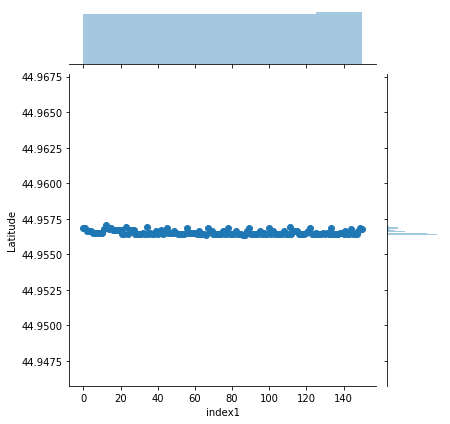

In [343]:
import seaborn as sns
import scipy.stats as stats #used to get correlation coefficient

j=sns.jointplot(x='index1', y='Latitude', data= CC_Sher1)

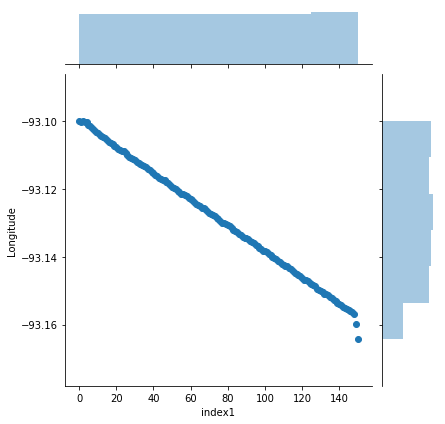

In [345]:
import seaborn as sns
import scipy.stats as stats #used to get correlation coefficient

j=sns.jointplot(x='index1', y='Longitude', data= CC_Sher1)

It looks like there is a section of the data that is not picking up the right coordinates, lets change the first 50 index of values with a different zip-code to see if that improved the score.

### Spotting outliers and data cleanup <a name="out"></a>


When looking for outliers, **you cannot rely on the graph alone**. We will do another example to illustrate this (i.e. Lexingtion Parkway)

In [316]:
#abs_alg('Fuller Ave','55104')
abs_alg('Lexington Parkway','55104')

B=df.loc[0:50,:]
C=df.loc[51:100,:]
D=df.loc[101:,]

(151, 4)


In [ ]:
#run_geo_algorithm(B,['55104']) #notice missing values and differnt zip code
#run_geo_algorithm(C,['55104']) 
#run_geo_algorithm(D,['55104']) 

In [407]:
#Add_Com=pd.concat([B,C,D])
#CC= Add_Com[['Block','For_Address','Latitude','Longitude','Fail']]
#CC_Lex=CC.reset_index()
#CC_Lex['index1'] = CC_Lex.index
plot_geomatch(CC_Lex)

Notice that the number of outliers differ from the map (Zoom out) compared to scatterplot below. The reason is that some of the outliers is mapped within the range of normal value and hence disguised. Thus a statistical approach should be used to find the index of the outliers. 

TypeError: Object of type ndarray is not JSON serializable

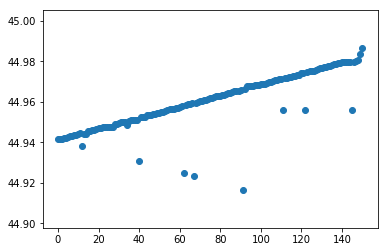

In [375]:
import mpld3
import scipy.stats as stats #used to get correlation coefficient
mpld3.enable_notebook()
import seaborn as sns
from mpld3 import plugins

CC_Lex=pd.read_csv('CC_Lex.csv')
x=CC_Lex.index1.values.tolist()
y=CC_Lex.Latitude.values.tolist()

fig, ax = plt.subplots()
points = ax.scatter(x,y,
                    s=50, alpha=0.3)

labels = ["Point {0}".format(i) for i in range(151)]
tooltip = plugins.PointLabelTooltip(points, labels)

plugins.connect(fig, tooltip)

scatter= plt.scatter(CC_Lex.index1, CC_Lex.Latitude)

### Data Cleanup <a name="decode_clean"></a>

As oppose to create a separate csv files with the messed up addresses and manually fixing them, you can correct the respective coordinate. This is acceptable if the coordinates are linear. 

Consider documenting the file changes prior to exporting the final block csv file. We can automate fixes without evening search up the data using the average of values preceding and succeeding index.

TypeError: Object of type ndarray is not JSON serializable

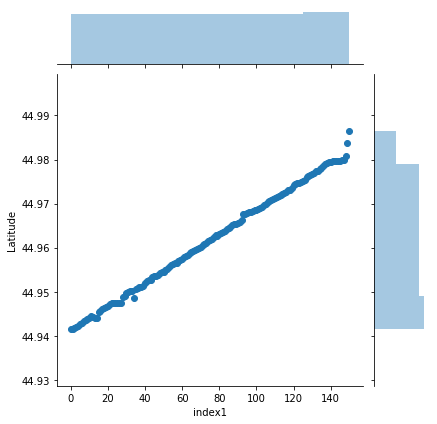

In [442]:

Index=[12,40,62,67,91,111,122,145]

for i in Index:
    CC_Lex.iloc[[i],[3]]= (CC_Lex.iloc[[i-1],[3]].values + CC_Lex.iloc[[i+1],[3]].values)/2 
    
import seaborn as sns
import scipy.stats as stats #used to get correlation coefficient

# Plot the graph to see that outliers are taken care of
j=sns.jointplot(x='index1', y='Latitude', data= CC_Lex)